# 1. Описание данных
Dataset: "Los Angeles Building and Safety Permits" — это набор данных, который содержит информацию о разрешениях на строительство, выданных в городе Лос-Анджелес. Данные включают различные атрибуты, такие как тип разрешения, его описание, дата подачи, адрес, разрешенная площадь, стоимость и другие параметры. Эти данные можно использовать для анализа тенденций в строительстве, выявления аномальных случаев или прогнозирования будущих разрешений.

# 2. Предложение задачи
Задача, которую можно решить на этом наборе данных:
Предсказание вероятности одобрения разрешения или классификация типов разрешений на основе данных о характеристиках разрешений.

К примеру, мы можем решить задачу классификации, где целью будет классификация разрешений на строительство по типу (например, разрешение на жилое, коммерческое или промышленное строительство). Это позволит городским органам лучше планировать распределение ресурсов или следить за соблюдением норм.

# 3. Выбор алгоритма машинного обучения
Для этой задачи хорошо подойдет алгоритм классификации, так как мы имеем категориальную цель — тип разрешения. Я бы выбрал следующие алгоритмы:

Логистическая регрессия — для классификации, если признаки линейно разделимы, это простой и интерпретируемый алгоритм.
Случайный лес (Random Forest) — более сложный, но мощный алгоритм, который хорошо работает с категориальными и числовыми признаками. Он также поможет в случае наличия коллинеарности между признаками.
Градиентный бустинг (XGBoost или LightGBM) — эффективные алгоритмы для сложных задач, где важно учитывать взаимодействия между признаками и минимизировать ошибки.
Для начала можно попробовать все три метода, чтобы увидеть, какой из них дает наилучший результат.

# 4. Методы оценивания эффективности алгоритма
Для оценки эффективности работы алгоритма будем использовать следующие методы:

Точность (Accuracy) — процент правильно предсказанных классов.
Матрица ошибок (Confusion Matrix) — для более детального анализа, сколько классов было предсказано неправильно.
F1-score — баланс между точностью и полнотой, полезен для случаев с несбалансированными классами.
ROC AUC — для оценки качества классификации в условиях дисбаланса классов.

# 5. Решение
**1. Загрузка и первоначальный анализ данных**

In [10]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("cityofLA/los-angeles-building-and-safety-permits")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/cityofLA/los-angeles-building-and-safety-permits/versions/11


In [11]:
import os

dataset_path = "/root/.cache/kagglehub/datasets/cityofLA/los-angeles-building-and-safety-permits/versions/11"

# список файлов
print(os.listdir(dataset_path))


['building-and-safety-permit-information.csv', 'socrata_metadata_building-and-safety-temporary-special-event-tse-permits.json', 'building-and-safety-temporary-special-event-tse-permits.csv', 'socrata_metadata_building-and-safety-permit-information.json']


In [12]:
!mkdir -p /content/dataset
!cp -r /root/.cache/kagglehub/datasets/cityofLA/los-angeles-building-and-safety-permits/versions/11/* /content/dataset/

In [13]:
# Загрузка данных
dataset_path = "/content/dataset/building-and-safety-permit-information.csv"
df = pd.read_csv(dataset_path)

<ipython-input-13-71f5a810eaac>:3: DtypeWarning: Columns (1,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(dataset_path)


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report)
from xgboost import XGBClassifier

In [15]:
# Настройка параметров для полного отображения столбцов и без ограничения ширины
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

first_five_rows = df.head()
display(first_five_rows)

,Assessor Book,Assessor Page,Assessor Parcel,Tract,Block,Lot,Reference # (Old Permit #),PCIS Permit #,Status,Status Date,Permit Type,Permit Sub-Type,Permit Category,Project Number,Event Code,Initiating Office,Issue Date,Address Start,Address Fraction Start,Address End,Address Fraction End,Street Direction,Street Name,Street Suffix,Suffix Direction,Unit Range Start,Unit Range End,Zip Code,Work Description,Valuation,Floor Area-L.A. Zoning Code Definition,# of Residential Dwelling Units,# of Accessory Dwelling Units,# of Stories,Contractor's Business Name,Contractor Address,Contractor City,Contractor State,License Type,License #,Principal First Name,Principal Middle Name,Principal Last Name,License Expiration Date,Applicant First Name,Applicant Last Name,Applicant Business Name,Applicant Address 1,Applicant Address 2,Applicant Address 3,Zone,Occupancy,Floor Area-L.A. Building Code Definition,Census Tract,Council District,Latitude/Longitude,Applicant Relationship,Existing Code,Proposed Code,Zip Codes,Census Tracts,Precinct Boundaries,LA Specific Plans,Council Districts,Neighborhood Councils (Certified)
0,4317.0,3.0,***,TR 30210-C,NaN,LT 1,NaN,15044-90000-08405,Permit Finaled,2015-09-10T00:00:00.000,HVAC,1 or 2 Family Dwelling,No Plan Check,NaN,NaN,INTERNET,2015-08-18T00:00:00.000,1823.0,1/2,1823.0,1/2,S,THAYER,AVE,NaN,NaN,NaN,90025.0,NaN,NaN,NaN,NaN,NaN,NaN,CONDITIONED AIRE MECHANICAL & ENGINEERING INC,18650 PARTHENIA STREET,NORTHRIDGE,CA,C20,532440.0,BRETT,MOORE,HOFFER,2016-06-30T00:00:00.000,BRETT,HOFFER,NaN,18650 PARTHENIA ST,NaN,"NORTHRIDGE, CA",R3-1-O,NaN,0.0,2671.00,5.0,"{'longitude': '-118.42628', 'human_address': '...",Net Applicant,NaN,NaN,23443.0,859.0,738.0,9.0,6.0,75.0
1,5005.0,10.0,017,CHESTERFIELD SQUARE,NaN,465,16SL57806,16016-70000-02464,Permit Finaled,2017-08-01T00:00:00.000,Bldg-Alter/Repair,1 or 2 Family Dwelling,No Plan Check,NaN,NaN,SOUTH LA,2016-02-04T00:00:00.000,2122.0,NaN,2122.0,NaN,W,54TH,ST,NaN,NaN,NaN,90062.0,General rehabilitation for single family dwell...,40000.0,NaN,NaN,NaN,NaN,OWNER-BUILDER,NaN,NaN,NaN,NaN,0.0,JAVIER,NaN,TALAMANTES,NaN,JAVIER,TALAMANTES,OWNER-BUILDER,NaN,NaN,NaN,C2-1VL,NaN,NaN,2325.00,8.0,"{'longitude': '-118.31668', 'human_address': '...",Owner-Bldr,1.0,NaN,24027.0,743.0,622.0,7.0,14.0,35.0
2,5154.0,23.0,022,SUN-SET TRACT,D,13,14VN81535,14016-20000-13092,Issued,2014-08-13T00:00:00.000,Bldg-Alter/Repair,Apartment,Plan Check,NaN,NaN,VAN NUYS,2014-08-13T00:00:00.000,415.0,NaN,415.0,NaN,S,BURLINGTON,AVE,NaN,1-30,1-30,90057.0,PHOTOVOLTAIC SOLAR PANELS ON ROOF OF (E) APT BLDG,37000.0,NaN,NaN,NaN,NaN,PERMACITY CONSTRUCTION CORP,5570 W WASHINGTON BLVD,LOS ANGELES,CA,B,827864.0,JONATHAN,SAUL,PORT,2015-11-30T00:00:00.000,LINDA,MARTON,NaN,710 WILSHIRE BLVD,NaN,"SANTA MONICA, CA",R4-1,NaN,NaN,2089.04,1.0,"{'longitude': '-118.26997', 'human_address': '...",Agent for Owner,5.0,NaN,24352.0,563.0,836.0,NaN,11.0,67.0
3,4404.0,30.0,010,TR 12086,NaN,2,NaN,16044-30000-09658,Permit Finaled,2016-08-29T00:00:00.000,HVAC,1 or 2 Family Dwelling,No Plan Check,NaN,NaN,WEST LA,2016-08-22T00:00:00.000,315.0,NaN,315.0,NaN,S,OCEANO,DR,NaN,NaN,NaN,90049.0,NaN,NaN,NaN,NaN,NaN,NaN,E/C HEATING AND AIR CONDITION,26888 CUATRO MILPAS ST,VALENCIA,CA,C20,651051.0,EDY,RUDOLFO,CORDON,2018-07-31T00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,RS-1,NaN,0.0,2640.00,11.0,"{'longitude': '-118.4732', 'human_address': '{...",Contractor,NaN,NaN,23680.0,840.0,1219.0,9.0,10.0,NaN
4,2646.0,19.0,011,TR 7158,NaN,11,NaN,17042-90000-31792,Permit Finaled,2017-12-28T00:00:00.000,Plumbing,1 or 2 Family Dwelling,No Plan Check,NaN,NaN,INTERNET,2017-12-26T00:00:00.000,13640.0,NaN,13640.0,NaN,W,PIERCE,ST,NaN,NaN,NaN,91331.0,NaN,NaN,NaN,NaN,NaN,NaN,TITANIUM POWER INC,1545 S LA CIENEGA BLVD,LOS ANGELES,CA,B,989217.0,DENNIS,HARUO,MIYAHIRA,2017-12-31T00:00:00.000,YONI,GHERMEZI,NaN,1545 S LA CIENEGA BLVD,NaN,"LOS ANGELES, CA",R1-1-O,NaN,0.0,1044.03,7.0,"{'longitude': '-118.43002', 'human_address': '...",Net Applicant,NaN,NaN,18907.0,26.0,408.0,NaN,1.0,11.0


In [16]:
# Вывод информации о датасете: типы данных и количество ненулевых значений
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1082006 entries, 0 to 1082005
Data columns (total 65 columns):
 #   Column                                    Non-Null Count    Dtype  
---  ------                                    --------------    -----  
 0   Assessor Book                             1080796 non-null  float64
 1   Assessor Page                             1080796 non-null  object 
 2   Assessor Parcel                           1080796 non-null  object 
 3   Tract                                     1077477 non-null  object 
 4   Block                                     210541 non-null   object 
 5   Lot                                       1074314 non-null  object 
 6   Reference # (Old Permit #)                481448 non-null   object 
 7   PCIS Permit #                             1082006 non-null  object 
 8   Status                                    1082006 non-null  object 
 9   Status Date                               1082006 non-null  object 
 10  Permit

In [17]:
# Статистическое описание числовых признаков
display(df.describe())

,Assessor Book,Project Number,Address Start,Address End,Zip Code,Valuation,Floor Area-L.A. Zoning Code Definition,# of Residential Dwelling Units,# of Accessory Dwelling Units,# of Stories,License #,Floor Area-L.A. Building Code Definition,Census Tract,Council District,Existing Code,Proposed Code,Zip Codes,Census Tracts,Precinct Boundaries,LA Specific Plans,Council Districts,Neighborhood Councils (Certified)
count,1.080796e+06,10838.000000,1.082003e+06,1.081998e+06,1.081937e+06,4.103890e+05,9.355700e+04,49524.000000,12745.000000,91383.000000,1.081987e+06,8.567420e+05,1.081315e+06,1.081505e+06,313991.000000,140212.000000,1.021415e+06,1.021386e+06,1.021381e+06,357373.000000,1.021206e+06,972748.000000
mean,4.132247e+03,4.293504,6.538980e+03,6.539687e+03,9.054652e+04,1.495141e+05,3.783561e+03,1.779279,0.870694,1.439086,6.672611e+05,3.078291e+02,2.060534e+03,7.986681e+00,6.071856,22.205845,2.003365e+04,5.333501e+02,8.868647e+02,11.146074,7.572607e+00,49.901263
std,1.456182e+03,1.506939,5.969391e+03,5.971712e+03,9.721529e+02,2.759392e+06,3.154205e+04,20.663742,8.127268,18.383537,3.653784e+05,1.073488e+04,1.166467e+03,4.211918e+00,8.612857,21.594645,6.235350e+03,3.578628e+02,3.802497e+02,8.561806,3.820563e+00,27.585576
min,9.000000e+00,1.000000,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,-1.541510e+05,-91.000000,-914.000000,-2.000000,0.000000e+00,-8.260560e+05,1.011100e+03,1.000000e+00,0.000000,0.000000,3.220000e+03,1.000000e+00,1.700000e+01,1.000000,1.000000e+00,1.000000
25%,2.542000e+03,5.000000,1.442000e+03,1.442000e+03,9.003200e+04,2.000000e+03,5.400000e+01,0.000000,1.000000,0.000000,4.916750e+05,0.000000e+00,1.344220e+03,4.000000e+00,1.000000,2.000000,1.933000e+04,2.890000e+02,5.700000e+02,7.000000,5.000000e+00,26.000000
50%,4.324000e+03,5.000000,4.810000e+03,4.810000e+03,9.006600e+04,8.000000e+03,5.200000e+02,0.000000,1.000000,1.000000,7.782660e+05,0.000000e+00,1.993000e+03,8.000000e+00,1.000000,20.000000,2.307900e+04,4.910000e+02,8.530000e+02,9.000000,7.000000e+00,49.000000
75%,5.215000e+03,5.000000,1.045500e+04,1.045500e+04,9.133100e+04,3.000000e+04,2.125000e+03,1.000000,1.000000,2.000000,9.367130e+05,0.000000e+00,2.404010e+03,1.200000e+01,7.000000,23.000000,2.367600e+04,8.000000e+02,1.228000e+03,10.000000,1.000000e+01,76.000000
max,7.563000e+03,5.000000,7.224400e+04,8.411300e+04,9.180300e+04,5.838003e+08,1.788210e+06,1150.000000,2.000000,3651.000000,8.831821e+07,2.188552e+06,9.800310e+03,1.500000e+01,70.000000,70.000000,2.632700e+04,2.342000e+03,1.560000e+03,54.000000,1.500000e+01,95.000000


**2. Дополнительные проверки данных**

In [22]:
# Проверка на наличие пропусков в данных
print(df.isnull().sum())

Assessor Book                           939
Assessor Page                           939
Assessor Parcel                         939
Tract                                  3653
Block                                691814
                                      ...  
Census Tracts                         47839
Precinct Boundaries                   47841
LA Specific Plans                    575099
Council Districts                     47979
Neighborhood Councils (Certified)     86476
Length: 65, dtype: int64


In [23]:
# Проверка на дубликаты ( здесь возможно ошибка)
print("До удаления дубликатов:", df.shape[0])
df = df.drop_duplicates()
duplicates = df.duplicated().sum()
print("\nКоличество дубликатов:", duplicates)
if duplicates > 0:
    df.drop_duplicates(inplace=True)
    print("Дубликаты удалены. Новое количество записей:", df.shape[0])

До удаления дубликатов: 858511

Количество дубликатов: 0


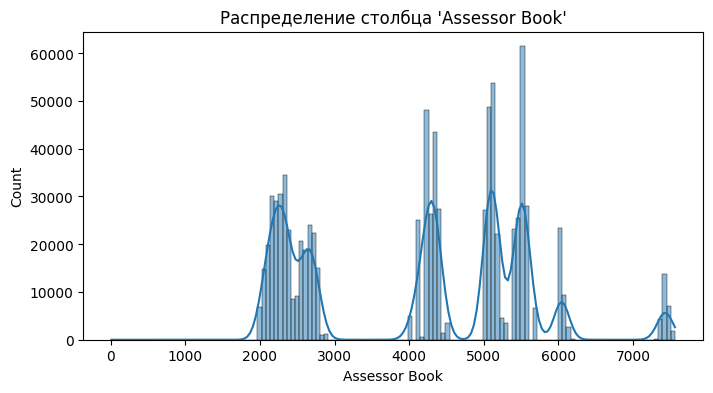

In [24]:
# Числовой столбец для анализа
if 'Assessor Book' in df.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(df['Assessor Book'], kde=True)
    plt.title("Распределение столбца 'Assessor Book'")
    plt.show()

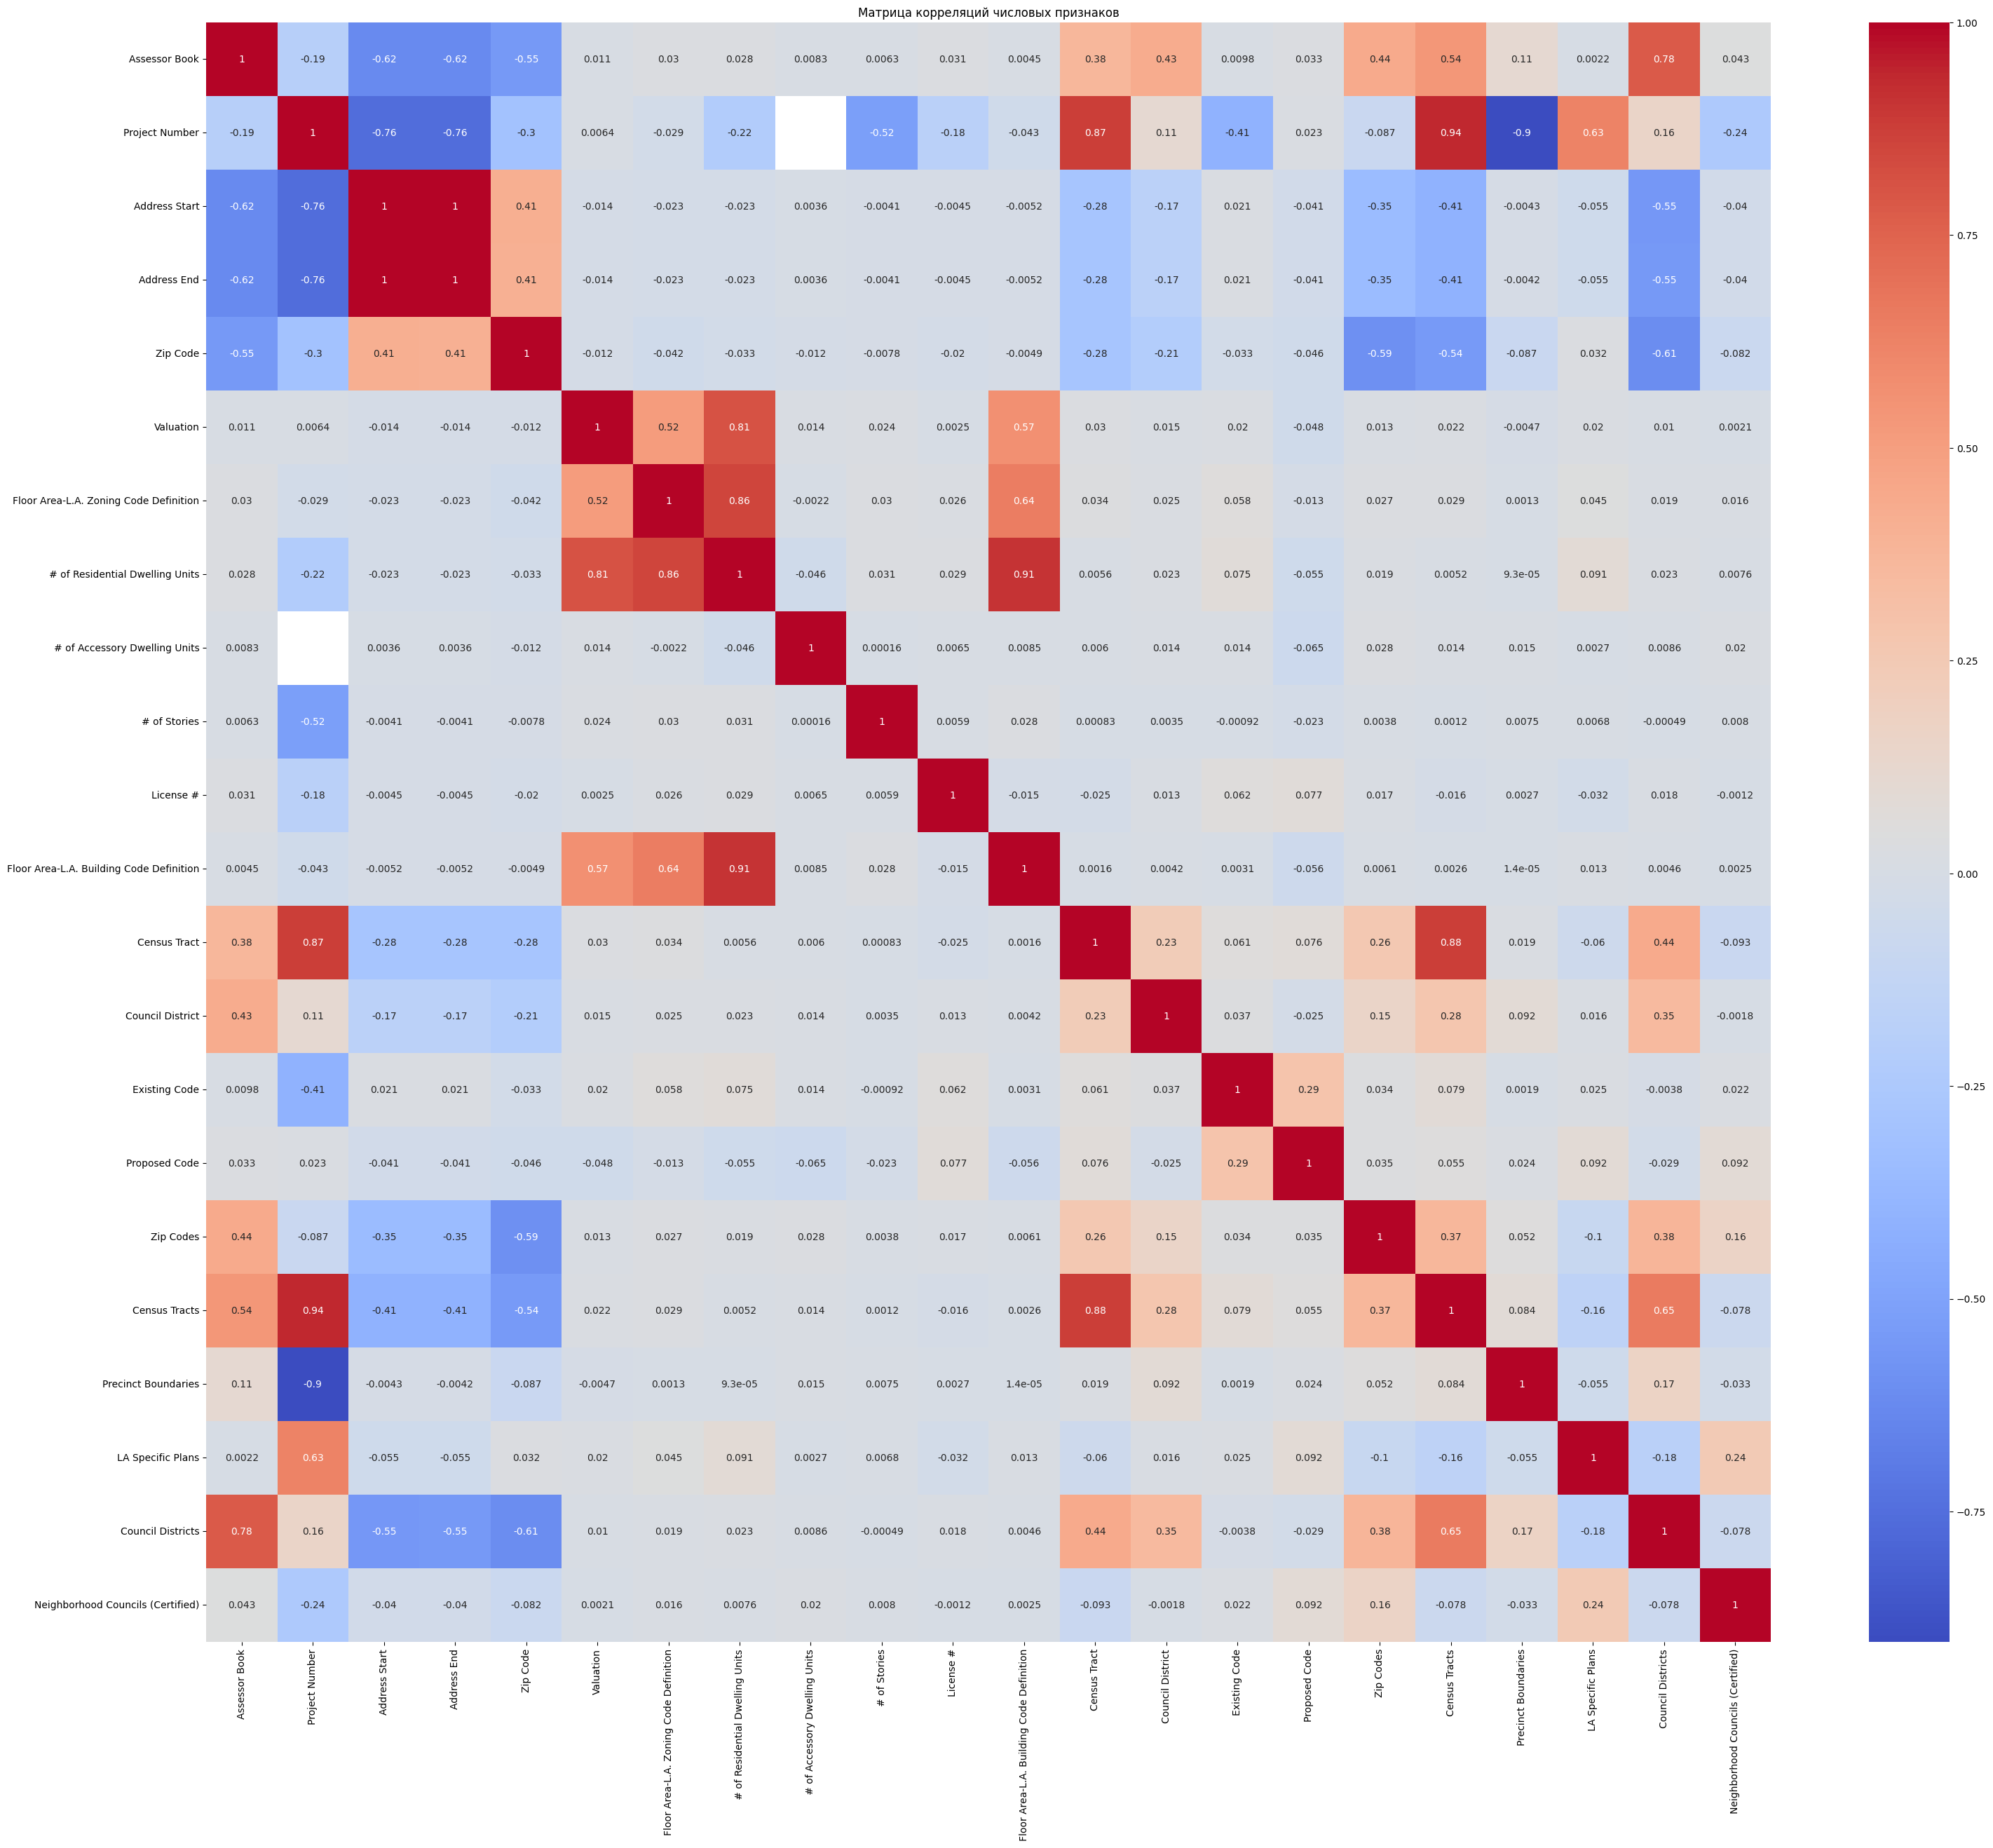

In [25]:
# Выбираем только числовые столбцы
numeric_df = df.select_dtypes(include=[np.number])

# Построение матрицы корреляций для числовых признаков
plt.figure(figsize=(36,30))
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Матрица корреляций числовых признаков")
plt.show()

3. Предобработка данных

In [26]:
df.fillna(method='ffill', inplace=True)
print("\nПосле заполнения пропусков:")
print(df.isnull().sum())

<ipython-input-26-ef7a66d27431>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)



После заполнения пропусков:
Assessor Book                        0
Assessor Page                        0
Assessor Parcel                      0
Tract                                0
Block                                2
                                    ..
Census Tracts                        0
Precinct Boundaries                  0
LA Specific Plans                    0
Council Districts                    0
Neighborhood Councils (Certified)    0
Length: 65, dtype: int64


In [27]:
if 'target' not in df.columns:
    if 'Permit Type' in df.columns:
        print("\nСтолбец 'target' не найден. Создаем его на основе 'Permit Type'.")
        df['target'] = df['Permit Type']
    else:
        raise ValueError("В данных отсутствует и 'target', и 'Permit Type' для формирования целевой переменной.")


Столбец 'target' не найден. Создаем его на основе 'Permit Type'.


**4. Выбор признаков и целевой переменной**

In [28]:
# Выделяем признаки и целевую переменную (исключая 'target' из X)
X = df.drop(['target'], axis=1)
y = df['target']

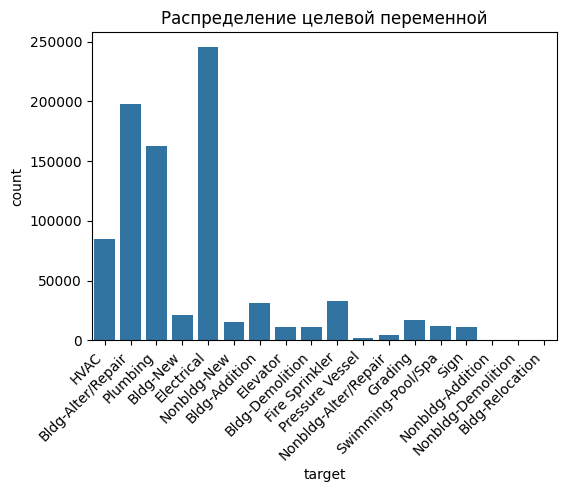

In [29]:
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.xticks(rotation=45, ha="right")
plt.title("Распределение целевой переменной")
plt.show()

In [30]:
print("\nРаспределение целевой переменной:")
print(y.value_counts())


Распределение целевой переменной:
target
Electrical              245698
Bldg-Alter/Repair       197995
Plumbing                162534
HVAC                     84456
Fire Sprinkler           33166
Bldg-Addition            30831
Bldg-New                 20905
Grading                  17171
Nonbldg-New              14865
Swimming-Pool/Spa        11490
Bldg-Demolition          11440
Sign                     10927
Elevator                 10890
Nonbldg-Alter/Repair      4326
Pressure Vessel           1584
Nonbldg-Addition           170
Nonbldg-Demolition          56
Bldg-Relocation              7
Name: count, dtype: int64


In [4]:
df_cleaned = df.dropna()

# Преобразование всех данных в числовой формат (чтобы избежать ошибок при вычислении корреляции)
numeric_df = df_cleaned.apply(pd.to_numeric, errors='coerce')

# Вычисляем матрицу корреляций
corr_matrix = numeric_df.corr()

# Построение тепловой карты
plt.figure(figsize=(40,40))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Настройки подписей осей
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

plt.title("Матрица корреляций числовых признаков", pad=20)
plt.tight_layout()  # Автоматическая подстройка

plt.show()

NameError: name 'df' is not defined

**5. Разделение данных на обучающую и тестовую**

**6. Обучение и оценка модели RandomForest**